<a href="https://colab.research.google.com/github/DurgaBhavana/5731Submissions/blob/master/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
pip install pyldavis

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
# Import Dataset
df = pd.read_csv('/content/Data Science_Extracts from Web.csv', encoding = 'ISO-8859-1')
# print(df.target_names.unique())
df.head()

,Data Science Titles
0,Data science in action
1,Data science and its relationship to big data ...
2,Data Science for Business: What you need to kn...
3,Data science and prediction
4,"Data science, predictive analytics, and big da..."


In [6]:
# Convert to list
data = df["Data Science Titles"].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Data science in action']


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['data', 'science', 'in', 'action']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['data', 'science', 'in', 'action']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['datum', 'science', 'action']]


In [52]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1)]]


[[('action', 1), ('datum', 1), ('science', 1)]]

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.066*"citation" + 0.034*"count" + 0.034*"web" + 0.034*"science" + '
  '0.034*"datum" + 0.034*"ranking" + 0.034*"review" + 0.034*"faculty" + '
  '0.034*"impact" + 0.034*"source"'),
 (1,
  '0.092*"datum" + 0.032*"orientation" + 0.032*"vegetation" + 0.032*"base" + '
  '0.032*"data" + 0.032*"system" + 0.032*"management" + 0.032*"space" + '
  '0.032*"science" + 0.032*"time"'),
 (2,
  '0.050*"trap" + 0.050*"analysis" + 0.050*"big" + 0.050*"datum" + '
  '0.050*"result" + 0.050*"international" + 0.050*"science" + '
  '0.002*"technique" + 0.002*"storage" + 0.002*"summarize"'),
 (3,
  '0.079*"science" + 0.079*"datum" + 0.048*"analytic" + 0.032*"new" + '
  '0.032*"workflow" + 0.016*"mining" + 0.016*"business" + 0.016*"nee" + '
  '0.016*"know" + 0.016*"thinking"'),
 (4,
  '0.066*"science" + 0.066*"datum" + 0.034*"method" + 0.034*"comprehensive" + '
  '0.034*"statistic" + 0.034*"industry" + 0.034*"application" + '
  '0.034*"reference" + 0.034*"mining" + 0.034*"material"'),
 (5,
  '0.058*"m

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.560018550153942

Coherence Score:  0.44714430785615555


In [15]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [16]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [17]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-10-23 01:24:15--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  17.9MB/s    in 0.9s    

2020-10-23 01:24:16 (17.9 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [22]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('age', 0.1111111111111111),
   ('computer', 0.1111111111111111),
   ('system', 0.1111111111111111),
   ('reconnaissance', 0.05555555555555555),
   ('art', 0.05555555555555555),
   ('text', 0.05555555555555555),
   ('school', 0.05555555555555555),
   ('combined', 0.05555555555555555),
   ('experimental', 0.05555555555555555),
   ('customer', 0.05555555555555555)]),
 (4,
  [('datum', 0.46875),
   ('protein', 0.125),
   ('story', 0.03125),
   ('cross', 0.03125),
   ('processing', 0.03125),
   ('develop', 0.03125),
   ('reduce', 0.03125),
   ('problem', 0.03125),
   ('free', 0.03125),
   ('imputation', 0.03125)]),
 (1,
  [('data', 0.3448275862068966),
   ('change', 0.10344827586206896),
   ('citizen', 0.10344827586206896),
   ('climate', 0.06896551724137931),
   ('perspective', 0.034482758620689655),
   ('construct', 0.034482758620689655),
   ('pass', 0.034482758620689655),
   ('supply', 0.034482758620689655),
   ('comprehensive', 0.034482758620689655),
   ('yield', 0.03448275862

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [72]:
coherence_values

[0.6855025932932781,
 0.7448775712891128,
 0.7648371571984978,
 0.7659222936908044,
 0.7369858217257058,
 0.7387496533045574,
 0.7263955481135715]

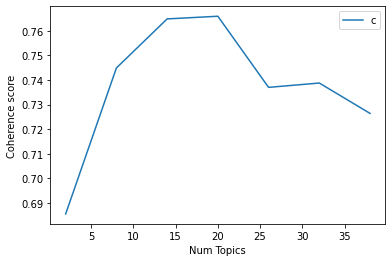

In [71]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6855
Num Topics = 8  has Coherence Value of 0.7449
Num Topics = 14  has Coherence Value of 0.7648
Num Topics = 20  has Coherence Value of 0.7659
Num Topics = 26  has Coherence Value of 0.737
Num Topics = 32  has Coherence Value of 0.7387
Num Topics = 38  has Coherence Value of 0.7264


In [28]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.176*"change" + 0.059*"mapping" + 0.059*"deletion" + 0.059*"computational" '
  '+ 0.059*"revolution" + 0.059*"promise" + 0.059*"analysis" + '
  '0.059*"orientation" + 0.059*"fundamental" + 0.059*"hirise"'),
 (1,
  '0.536*"datum" + 0.036*"social" + 0.036*"history" + 0.036*"storage" + '
  '0.036*"study" + 0.036*"tool" + 0.036*"engineering" + 0.036*"miss" + '
  '0.036*"key" + 0.036*"fundamental"'),
 (2,
  '0.211*"protein" + 0.105*"discovery" + 0.053*"law" + 0.053*"falsify" + '
  '0.053*"multivariate" + 0.053*"cluster" + 0.053*"evaluate" + 0.053*"enhance" '
  '+ 0.053*"aqueous" + 0.053*"pass"'),
 (3,
  '0.208*"datum" + 0.167*"method" + 0.125*"analysis" + 0.083*"stream" + '
  '0.042*"define" + 0.042*"mission" + 0.042*"introduction" + 0.042*"develop" + '
  '0.042*"covariance" + 0.042*"faculty"'),
 (4,
  '0.118*"analyze" + 0.059*"statistical" + 0.059*"grid" + 0.059*"intensive" + '
  '0.059*"citizen" + 0.059*"mineralogical" + 0.059*"challenge" + '
  '0.059*"experiment" + 0.059*"time" 

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [35]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [36]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [66]:
def compute_coherence_values_lsa(dictionary, doc_term_matrix, doc_clean, start, limit, step):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [67]:
model_list_lsa, coherence_lsa = compute_coherence_values_lsa(id2word,corpus,data_lemmatized,start=2,limit=40,step=6)

In [69]:
# Select the model and print the topics
optimal_model_lsa = model_list_lsa[5]
model_topics_lsa = optimal_model_lsa.show_topics(formatted=False)
pprint(optimal_model_lsa.print_topics(num_words=10))

[(0,
  '0.760*"datum" + 0.554*"science" + 0.106*"mining" + 0.097*"big" + '
  '0.082*"analytic" + 0.063*"knowledge" + 0.055*"relationship" + 0.054*"data" '
  '+ 0.054*"management" + 0.050*"business"'),
 (1,
  '0.747*"science" + -0.531*"datum" + -0.128*"big" + 0.087*"research" + '
  '0.081*"change" + -0.077*"protein" + -0.068*"analytic" + -0.067*"mining" + '
  '0.054*"scientific" + 0.054*"citizen"'),
 (2,
  '-0.621*"data" + -0.371*"nuclear" + -0.233*"endf" + -0.233*"vii" + '
  '-0.233*"technology" + -0.158*"structure" + -0.143*"product" + -0.139*"next" '
  '+ -0.138*"evaluate" + -0.138*"generation"'),
 (3,
  '0.388*"data" + 0.378*"big" + 0.276*"analytic" + 0.245*"new" + '
  '-0.232*"nuclear" + -0.178*"endf" + -0.178*"vii" + -0.178*"technology" + '
  '-0.174*"protein" + 0.125*"structure"'),
 (4,
  '0.293*"protein" + 0.293*"data" + -0.273*"big" + 0.263*"network" + '
  '-0.244*"analytic" + -0.241*"new" + -0.221*"nuclear" + 0.185*"fair" + '
  '-0.161*"technology" + -0.161*"endf"'),
 (5,
  '0

In [ ]:
Total Number of Documents: 4551
[(0, '0.361*"trump" + 0.272*"say" + 0.233*"said" + 0.166*"would" + 0.160*"clinton" + 0.140*"peopl" + 0.136*"one" + 0.126*"campaign" + 0.123*"year" + 0.110*"time"'), (1, '-0.389*"citi" + -0.370*"v" + -0.356*"h" + -0.355*"2016" + -0.354*"2017" + -0.164*"unit" + -0.159*"west" + -0.157*"manchest" + -0.116*"apr" + -0.112*"dec"'), (2, '0.612*"trump" + 0.264*"clinton" + -0.261*"eu" + -0.148*"say" + -0.137*"would" + 0.135*"donald" + -0.134*"leav" + -0.134*"uk" + 0.119*"republican" + -0.110*"cameron"'), (3, '-0.400*"min" + 0.261*"eu" + -0.183*"goal" + -0.152*"ball" + -0.132*"play" + 0.128*"said" + 0.128*"say" + -0.126*"leagu" + 0.122*"leav" + -0.122*"game"'), (4, '0.404*"bank" + -0.305*"eu" + -0.290*"min" + 0.189*"year" + -0.164*"leav" + -0.153*"cameron" + 0.143*"market" + 0.140*"rate" + -0.139*"vote" + -0.133*"say"'), (5, '0.310*"bank" + -0.307*"say" + -0.221*"peopl" + 0.203*"trump" + 0.166*"1" + 0.164*"min" + 0.163*"0" + 0.152*"eu" + 0.152*"market" + -0.138*"like"'), (6, '0.570*"say" + 0.237*"min" + -0.170*"vote" + 0.158*"govern" + -0.154*"poll" + 0.122*"tax" + 0.115*"statement" + 0.115*"bank" + 0.112*"budget" + -0.108*"one"')]


## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [73]:
"""


LSA performs matrix decomposition, it gives direct outputs the document similarities.
It outputs a matrix in the form of cosine similarity matrix.
whereas, LDA does not directly output the document similarities.
It outputs a matrix whose rows represent all the words and columns represent all the documents.
LSA is much faster to train than LDA and LDA has higher accuracy than LSA.
LDA overcomes all the drawbacks of LSA.
"""

'\n\n\nLSA performs matrix decomposition, it gives direct outputs the document similarities.\nIt outputs a matrix in the form of cosine similarity matrix.\nwhereas, LDA does not directly output the document similarities.\nIt outputs a matrix whose rows represent all the words and columns represent all the documents.\nLSA is much faster to train than LDA and LDA has higher accuracy than LSA.\nLDA overcomes all the drawbacks of LSA.\n'